# Introduction: Automated Hyperparameter Optimization

In this notebook we will walk through automated hyperparameter tuning using Bayesian Optimization. Specifically, we will optimize the hyperparameters of a Gradient Boosting Machine using the Hyperopt library (with the Tree Parzen Estimator algorithm).  We will compare the results of random search (implemented manually) for hyperparameter tuning with the Bayesian model-based optimization method to try and understand how the Bayesian method works and what benefits it has over uninformed search methods.  

## Hyperopt

Hyperopt is one of several automated hyperparameter tuning libraries using Bayesian optimization. These libraries differ in the algorithm used to both construct the surrogate (probability model) of the objective function and choose the next hyperparameters to evaluate in the objective function. Hyperopt uses the Tree Parzen Estimator (TPE). Other Python libraries include Spearmint, which uses a Gaussian process for the surrogate, and SMAC, which uses a random forest regression. 

Hyperopt has a simple syntax for structuring an optimization problem which extends beyond hyperparameter tuning to any problem that involves minimizing a function. Moreover, the structure of a Bayesian Optimization problem is similar across the libraries, with the major differences coming in the syntax (and in the algorithms behind the scenes that we do not have to deal with). 

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import random

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold

MAX_EVALS = 500
N_FOLDS = 5

## Data

For this notebook, we will work with the Caravan Insurance Challenge dataset [available on Kaggle](https://www.kaggle.com/uciml/caravan-insurance-challenge). The objective is to determine whether or not a potential customer will buy an insurance policy by training a model on past data. This is a straightforward supervised machine learning classification task: given past data, we want to train a model to predict a binary outcome on testing data.  

In [3]:
# Read in data and separate into training and testing sets
data = pd.read_csv('caravan-insurance-challenge.csv')
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

# Extract the labels and format properly
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

# Drop the unneeded columns
train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

# Convert to numpy array for splitting in cross validation
features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)
train.head()

Train shape:  (5822, 85)
Test shape:  (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


#### Distribution of Label

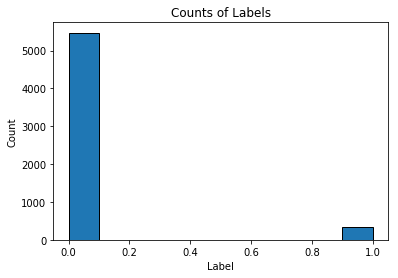

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(labels, edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

This is an imbalanced class problem: there are far more observations where an insurance policy was not bought (0) than when the policy was bought (1). Therefore, accuracy is a poor metric to use for this task. Instead, we will use the common classification metric of Receiver Operating Characteristic Area Under the Curve (ROC AUC). Randomly guessing on a classification problem will yield an ROC AUC of 0.5 and a perfect classifier has an ROC AUC of 1.0. For a better baseline model than random guessing, we can train a default Gradient Boosting Machine and have it make predictions.

### Gradient Boosting Machine Default Model

We will use the LightGBM implementation of the gradient boosting machine. This is much faster than the Scikit-Learn implementation and achieves results comparable to extreme gradient boosting, XGBoost. For the baseline model, we will use the default hyperparameters as specified in LightGBM.

Parameters in lightGBM:
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [11]:
# Model with default hyperparameters
model = lgb.LGBMClassifier()
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

All we need to do is fit the model on the training data and make predictions on the testing data. For the predictions, because we are measuring ROC AUC and not accuracy, we have the model predict probabilities and not hard binary values.

In [12]:
from sklearn.metrics import roc_auc_score, f1_score, fbeta_score, accuracy_score, confusion_matrix, auc, precision_recall_curve
from timeit import default_timer as timer

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
predictions2 = model.predict(test_features)
ROCauc = roc_auc_score(test_labels, predictions)
F1=f1_score(test_labels, predictions2)
accuracy=accuracy_score(test_labels, predictions2)
beta=0.1
Fbeta=fbeta_score(test_labels, predictions2,beta)
precision, recall, thresholds= precision_recall_curve(test_labels, predictions)
PRauc=auc(recall,precision)
confusionMatrix=confusion_matrix(test_labels, predictions2)

print('The baseline training time is {:.4f} seconds'.format(train_time))
print('The baseline accuracy score on the test set is {:.4f}.'.format(accuracy))
print('The baseline ROC-AUC score on the test set is {:.4f}.'.format(ROCauc))
print('The baseline F1 score on the test set is {:.4f}.'.format(F1))
print('The baseline Fbeta score with beta={} on the test set is {:.4f}.'.format(beta,Fbeta))
print('The baseline PRauc score on the test set is {:.4f}.'.format(PRauc))
print(confusionMatrix)



The baseline training time is 0.1740 seconds
The baseline accuracy score on the test set is 0.9357.
The baseline ROC-AUC score on the test set is 0.7092.
The baseline F1 score on the test set is 0.0919.
The baseline Fbeta score with beta=0.1 on the test set is 0.2771.
The baseline PRauc score on the test set is 0.1555.
[[3730   32]
 [ 225   13]]


That's our metric to beat. Due to the small size of the dataset (less than 6000 observations), hyperparameter tuning will have a modest but noticeable effect on the performance (a better investment of time might be to gather more data!)

# Random Search 

First we will implement a common technique for hyperparameter optimization: random search. Each iteration, we choose a random set of model hyperparameters from a search space. Empirically, random search is very effective, returning nearly as good results as grid search with a significant reduction in time spent searching. However, it is still an uninformed method in the sense that it does not use past evaluations of the objective function to inform the choices it makes for the next evaluation. 

Random search uses the following four parts, which also are used in Bayesian hyperparameter optimization:

1. Domain: values over which to search
2. Optimization algorithm: pick the next values at random! (yes this qualifies as an algorithm)
3. Objective function to minimize: in this case our metric is cross validation ROC AUC
4. Results history that tracks the hyperparameters tried and the cross validation metric

Random search can be implemented in the Scikit-Learn library using `RandomizedSearchCV`, however, because we are using Early Stopping (to determine the optimal number of estimators), we will have to implement the method ourselves (more practice!). This is pretty straightforward, and many of the ideas in random search will transfer over to Bayesian hyperparameter optimization. 

In [7]:
import random

## Domain for Random Search

Random search and Bayesian optimization both search for hyperparameters from a domain. For random (or grid search) this domain is called a hyperparameter grid and uses discrete values for the hyperparameters.

First, let's look at all of the hyperparamters that need to be tuned.

In [7]:
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Based on the default values, we can construct the following hyperparameter grid. It's difficult to say ahead of time what choices will work best, so we will use a wide range of values centered around the default for most of the hyperparameters. 

The `subsample_dist` will be used for the `subsample` parameter but we can't put it in the param grid because `boosting_type=goss` does not support row subsampling. Therefore we will use an `if` statement when choosing our hyperparameters to choose a subsample ratio if the boosting type is not `goss`.

In [8]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.5), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

In [126]:
#for key,value in param_grid.items():
    #print(random.sample(value,1)[0])

In [127]:
#random.sample(param_grid['boosting_type'],2)

Let's look at two of the distributions, the `learning_rate` and the `num_leaves`. The learning rate is typically [represented by a logarithmic distribution](https://www.quora.com/Why-does-one-sample-the-log-space-when-searching-for-good-Hyper-Parameters-for-Machine-Learning) because it can vary over several orders of magnitude. `np.logspace` returns values evenly spaced over a log-scale (so if we take the log of the resulting values, the distribution will be uniform.)

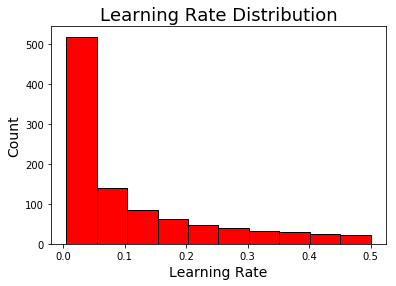

In [9]:
plt.hist(param_grid['learning_rate'], color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

Smaller values of the learning rate are more common with the values between 0.005 and 0.2. The width of the domain is fairly large indicating a large amount of uncertainty on our part about the optimal value (which we hope is somewhere in the grid)! 

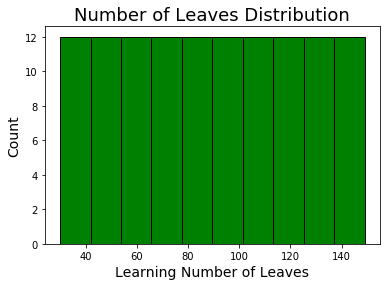

In [10]:
plt.hist(param_grid['num_leaves'], color = 'g', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

The number of leaves is a simple uniform domain.

### Sampling from Hyperparameter Domain

Let's look at how we sample a set of hyperparameters from our grid using a dictionary comprehension.

In [9]:
# Randomly sample parameters for gbm
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'class_weight': 'balanced',
 'boosting_type': 'goss',
 'num_leaves': 72,
 'learning_rate': 0.01984123052284741,
 'subsample_for_bin': 40000,
 'min_child_samples': 85,
 'reg_alpha': 0.14285714285714285,
 'reg_lambda': 0.9795918367346939,
 'colsample_bytree': 0.6}

To add a `subsample` ratio if the `boosting_type` is not `goss`, we can use an if statement.

In [10]:
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

{'class_weight': 'balanced',
 'boosting_type': 'goss',
 'num_leaves': 72,
 'learning_rate': 0.01984123052284741,
 'subsample_for_bin': 40000,
 'min_child_samples': 85,
 'reg_alpha': 0.14285714285714285,
 'reg_lambda': 0.9795918367346939,
 'colsample_bytree': 0.6,
 'subsample': 1.0}

We set the subsample to 1.0 if boosting type is goss which is the same as not using any subsampling. (Subsampling is when we train on a subset of the rows (observations) rather than all of them. This technique is also referred to as bagging for "bootstrap aggregating").

## Cross Validation with Early Stopping in LightGBM

The scikit-learn cross validation api does not include the option for early stopping. Therefore, we will use the LightGBM cross validation function with 100 early stopping rounds. To use this function, we need to create a dataset from our features and labels.

In [11]:
# Create a lgb dataset
train_set = lgb.Dataset(features, label = labels)

The `cv` function takes in the parameters, the training data, the number of training rounds, the number of folds, the metric, the number of early stopping rounds, and a few other arguments. We set the number of boosting rounds very high, but we will not actually train this many estimators because we are using early stopping to stop training when the validation score has not improved for 100 estimators. 

In [14]:
# Perform cross validation with 10 folds
r = lgb.cv(params, train_set, num_boost_round = 10000, nfold = 10, metrics = 'AUC', 
            early_stopping_rounds = 50, verbose_eval = False, seed = 50)

# Highest score
r_best = np.max(r['auc-mean'])

# Standard deviation of best score
r_best_std = r['auc-stdv'][np.argmax(r['auc-mean'])]

print('The maximium ROC AUC on the validation set was {:.5f} with std of {:.5f}.'.format(r_best, r_best_std))
print('The ideal number of iterations was {}.'.format(np.argmax(r['auc-mean']) + 1))

The maximium ROC AUC on the validation set was 0.75301 with std of 0.04533.
The ideal number of iterations was 4.


In [15]:
r.keys()

dict_keys(['auc-mean', 'auc-stdv'])

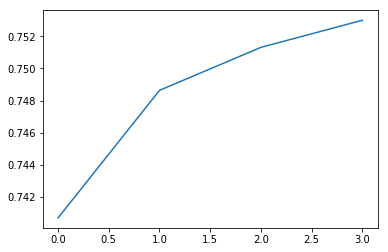

In [15]:
plt.plot(r['auc-mean'])

### Results Dataframe

We have our domain and our algorithm which in this case is random selection. The other two parts we need for an optimization problem are an objective function and a data structure to keep track of the results (these four parts will also be required in Bayesian Optimization). 

Tracking the results will be done via a `dataframe` where each row will hold one evaluation of the objective function.

In [16]:
# Dataframe to hold cv results for random sampling
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

### Objective Function

The objective function will take in the hyperparameters and return the validation loss (along with some other information to track the search progress). We already choose our metric as ROC AUC and now we need to figure out how to measure it. We can't evaluate the ROC AUC on the test set because that would be cheating. Instead we must use a validation set to tune the model and hope that the results translate to the test set. 

A better approach than drawing the validation set from the training data (thereby limiting the amount of training data we have) is KFold cross validation. In addition to not limiting the training data, this method should also give us a better estimate of generalization error on the test set because we will be using K validations rather than only one. For this example we will use 10-fold cross validation which means testing and training each set of model hyperparameters 10 times, each time using a different subset of the training data as the validation set. The objective function will return a list of information, including the validation AUC ROC. We also want to make sure to save the hyperparameters used so we know which ones are optimal (or the best out of those we tried).

In the case of random search, the next values selected are not based on the past evaluation results, but we clearly should keep track so we know what values worked the best! This will also allow us to contrast random search with informed Bayesian optimization.

In [17]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function (not using hyperband). Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    end = timer()
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]


## Random Search Implementation

Now we can write a loop to iterate through the number of evals, each time choosing a different set of hyperparameters to evaluate. Each time through the function, the results are saved to the dataframe. (The `%%capture` magic captures any outputs from running a cell in a Jupyter Notebook. This is useful because the output from a LightGBM training run cannot be suppressed.)

In [18]:
%%capture

random.seed(50)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

In [27]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

,Unnamed: 0,loss,params,iteration,estimators,time
0,0,0.239105,"{'class_weight': 'balanced', 'boosting_type': ...",0,4,0.961060
1,1,0.239180,"{'class_weight': 'balanced', 'boosting_type': ...",14,76,1.079268
2,2,0.239289,"{'class_weight': 'balanced', 'boosting_type': ...",38,198,1.820628
3,3,0.239328,"{'class_weight': None, 'boosting_type': 'gbdt'...",30,89,1.351559
4,4,0.239977,"{'class_weight': 'balanced', 'boosting_type': ...",64,33,294.083927


In [26]:
random_results.to_csv('random_results.csv')

In [14]:
#random_results=pd.read_csv('random_results.csv')

### Random Search Performance

As a reminder, the baseline gradient boosting model achieved a score of 0.71 on the training set. We can use the best parameters from random search and evaluate them on the testing set. 

What were the hyperparameters that returned the highest score on the objective function?

In [31]:
#to convert parameters to dictionary again. When we read the results parameters load as string for some reason.
import ast
random_results.loc[0, 'params']
print(ast.literal_eval(random_results.loc[0, 'params']))

{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 76, 'learning_rate': 0.10098928784099395, 'subsample_for_bin': 80000, 'min_child_samples': 460, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 1.0, 'colsample_bytree': 0.8222222222222222, 'subsample': 1.0}


The `estimators` key holds the average number of estimators trained with early stopping (averaged over 10 folds). We can use this as the optimal number of estimators in the gradient boosting model.

In [33]:
# Find the best parameters and number of estimators
best_random_params = ast.literal_eval(random_results.loc[0, 'params'])
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = -1, 
                                       objective = 'binary', **best_random_params, random_state = 50)

# Fit on the training data
best_random_model.fit(features, labels)

# Make test predictions
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('The best model from random search scores {:.4f} on the test data.'.format(roc_auc_score(test_labels, predictions)))
print('This was achieved using {} search iterations.'.format(random_results.loc[0, 'iteration']))

The best model from random search scores 0.7069 on the test data.
This was achieved using 0 search iterations.


A modest gain over the baseline. Using more evaluations might increase the score, but at the cost of more optimization time. We also have to remember that the hyperparameters are optimized on the validation data whigh may not translate to the testing data. 

Now, we can move on to Bayesian methods and see if they are able to achieve better results.

# Bayesian Hyperparameter Optimization using Hyperopt

For Bayesian optimization, we need the following four parts:

1. Objective function
2. Domain space
3. Hyperparameter optimization algorithm
4. History of results

We already used all of these in random search, but for Hyperopt we will have to make a few changes.

## Objective Function 

This objective function will still take in the hyperparameters but it will return not a list but a dictionary. The only requirement for an objective function in Hyperopt is that it has a key in the return dictionary called `"loss"` to minimize and a key called `"status"` indicating if the evaluation was successful. 

If we want to keep track of the number of iterations, we can declare a global variables called `ITERATION` that is incremented every time the function is called. In addition to returning comprehensive results, every time the function is evaluated, we will write the results to a new line of a csv file. This can be useful for extremely long evaluations if we want to check on the progress (this might not be the most elegant solution, but it's better than printing to the console because our results will be saved!) 

The most important part of this function is that now we need to return a __value to minimize__ and not the raw ROC AUC. We are trying to find the best value of the objective function, and even though a higher ROC AUC is better, Hyperopt works to minimize a function. Therefore, a simple solution is to return 1 - ROC (we did this for random search as well for practice).

In [16]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 'train_time': run_time, 'status': STATUS_OK}

In [37]:
#Dataframe to hold cv results for BO
BO_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

For some reason in the middle of the optimization run the permission to write on the file will be denied! So this alternate objective function doesn't write the results on a file, it saves the results in results_BO which we could save later: 

In [113]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
global i
i=0

def objective_BO(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    #of_connection = open(out_file, 'a')
    #writer = csv.writer(of_connection)
    #writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    results_BO = list([loss, params, ITERATION, n_estimators, run_time])
    
    global i
    # Add results to next row in dataframe
    BO_results.loc[i, :] = results_BO
    i+=1
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 'train_time': run_time, 'status': STATUS_OK}

Objective function for random search using hyperband.

In [35]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
global i
i=0

def objective_random(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    #of_connection = open(out_file, 'a')
    #writer = csv.writer(of_connection)
    #writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    results_RANDOM = list([loss, params, ITERATION, n_estimators, run_time])
    
    global i
    # Add results to next row in dataframe
    RANDOM_results.loc[i, :] = results_RANDOM
    i+=1
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 'train_time': run_time, 'status': STATUS_OK}

Although Hyperopt only needs the `loss`, it's a good idea to track other metrics so we can inspect the results. Later we can compare the sequence of searches to that from random search which will help us understand how the method works. 

## Domain Space

Specifying the domain (called the `space` in Hyperopt) is a little trickier than in grid search. In Hyperopt, and other Bayesian optimization frameworks, the domian is not a discrete grid but instead has probability distributions for each hyperparameter. For each hyperparameter, we will use the same limits as with the grid, but instead of being defined at each point, the domain represents probabilities for each hyperparameter. This will probably become clearer in the code and the images! 

In [36]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

First we will go through an example of the learning rate. Again, we are using a log-uniform space for the learning rate defined from 0.005 to 0.2 (same as with the grid from random search.) This time, when we graph the domain, it's more accurate to see a kernel density estimate plot than a histogram (although both show distributions). 

In [37]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.5))}

We can visualize the learning rate by sampling from the space using a Hyperopt utility. Here we plot 10000 samples.

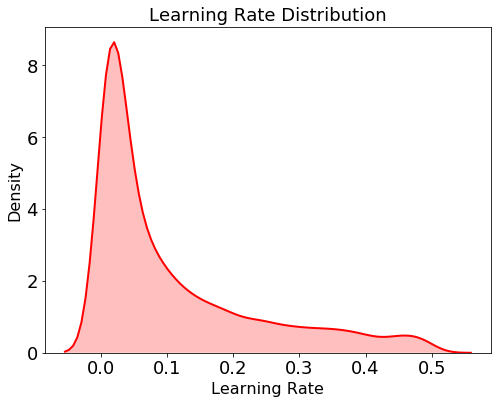

In [82]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); 
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

The number of leaves is again a uniform distribution. Here we used `quniform` which means a discrete uniform (as opposed to continuous).

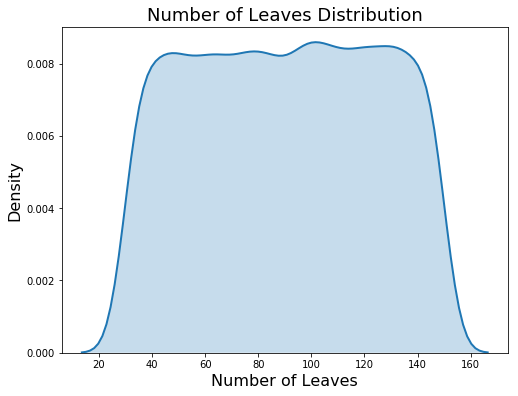

In [38]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

### Conditional Domain

In Hyperopt, we can use nested conditional statements to indicate hyperparameters that depend on other hyperparameters. For example, we know that `goss` boosting type cannot use subsample, so when we set up the `boosting_type` categorical variable, we have to se the `subsample` to 1.0 while for the other boosting types it's a float between 0.5 and 1.0 Let's see this with an example:

In [39]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
params = sample(boosting_type)
params

{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.6607006860992504}}

We need to set both the `boosting_type` and `subsample` as top-level keys in the parameter dictionary. We can use the Python `dict.get` method with a default value of 1.0. This means that if the key is not present in the dictionary, the value returned will be the default (1.0).

In [40]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = params['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
params['boosting_type'] = params['boosting_type']['boosting_type']
params['subsample'] = subsample

params

{'boosting_type': 'dart', 'subsample': 0.6607006860992504}

This is because the gbm cannot use the nested dictionary so we need to set the `boosting_type` and `subsample` as top level keys. Nested conditionals allow us to use a different set of hyperparameters depending on other hyperparameters. For example, we can explore different models with completely different sets of hyperparameters by using nested conditionals. The only requirement is that the first nested statement must be based on a `choice` hyperparameter (the choice could be the type of model).

## Complete Bayesian Domain

Now we can define the entire domain. Each variable needs to have a label and a few parameters specifying the type and extent of the distribution. For the variables such as boosting type that are categorical, we use the `choice` variable. Other variables types include `quniform`, `loguniform`, and `uniform`. For the complete list, check out the [documentation](https://github.com/hyperopt/hyperopt/wiki/FMin) for Hyperopt. 

In [41]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

### Example of Sampling from the Domain 

Let's sample from the domain (using the conditional logic) to see the result of each draw. Every time we run this code, the results will change. (Again notice that we need to assign the top level keys to the keywords understood by the GBM).

In [38]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6359555564698444,
 'learning_rate': 0.061030102682485085,
 'min_child_samples': 210.0,
 'num_leaves': 113.0,
 'reg_alpha': 0.37815659121606593,
 'reg_lambda': 0.7942842064174859,
 'subsample_for_bin': 200000.0,
 'subsample': 0.922897913699986}

In [31]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 0.6029525741954976,
 'learning_rate': 0.10959258266343275,
 'min_child_samples': 210.0,
 'num_leaves': 101.0,
 'reg_alpha': 0.19122280418849236,
 'reg_lambda': 0.4542212488654749,
 'subsample_for_bin': 300000.0,
 'subsample': 0.787351305603365}

## Optimization Algorithm

Although this is the most technical part of Bayesian optimization, defining the algorithm to use in Hyperopt is simple. We will use the Tree Parzen Estimator (read about it [in this paper](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)) which is one method for constructing the surrogate function and choosing the next hyperparameters to evaluate. 

In [42]:
from hyperopt import tpe,rand

# optimization algorithm
tpe_algorithm = tpe.suggest
rand_algo = rand.suggest

## Results History

The final part is the result history. Here, we are using two methods to make sure we capture all the results:

1. A `Trials` object that stores the dictionary returned from the objective function
2. Writing to a csv file every iteration

The csv file option also lets us monitor the results of an on-going experiment. (Although do not use Excel to open the file while training is on-going. Instead check the results using `tail results/gbm_trials.csv` from bash or another command line.

In [43]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()
rand_trials = Trials()

The `Trials` object will hold everything returned from the objective function in the `.results` attribute. It also holds other information from the search, but we return everything we need from the objective. 

In [26]:
# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

Every time the objective function is called, it will write one line to this file. Running the cell above does clear the file though.

## Bayesian Optimization

We have everything in place needed to run the optimization. First we declare the global variable that will be used to keep track of the number of iterations. Then, we call `fmin` passing in everything we defined above and the maximum number of iterations to run.

In [44]:
from hyperopt import fmin

In [92]:
#Dataframe to hold cv results for BO
BO_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

In [45]:
#Dataframe to hold cv results for BO
RANDOM_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

In [106]:
#MAX_EVALS = 5
#N_FOLDS = 2

In [114]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective_BO, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

In [117]:
BO_results.to_csv('BO_results.csv')

In [16]:
#BO_results= pd.read_csv('BO_results.csv')

In [17]:
BO_results.head()

,Unnamed: 0,loss,params,iteration,estimators,time
0,0,0.249621,"{'boosting_type': 'goss', 'class_weight': 'bal...",1,47,0.581314
1,1,0.273365,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",2,12,1.362947
2,2,0.240655,"{'boosting_type': 'goss', 'class_weight': 'bal...",3,10,0.452074
3,3,0.245325,"{'boosting_type': 'goss', 'class_weight': 'bal...",4,5,0.339758
4,4,0.240865,"{'boosting_type': 'gbdt', 'class_weight': None...",5,161,1.167774


In [122]:
bayes_trials.best_trial

{'state': 2,
 'tid': 70,
 'spec': None,
 'result': {'loss': 0.2369341831360271,
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.6014610964268584,
   'learning_rate': 0.10593108376711306,
   'min_child_samples': 205,
   'num_leaves': 30,
   'reg_alpha': 0.9554058687588726,
   'reg_lambda': 0.7551270460332415,
   'subsample_for_bin': 20000,
   'subsample': 0.7969085111663032},
  'iteration': 71,
  'estimators': 37,
  'train_time': 0.7136297479883069,
  'status': 'ok'},
 'misc': {'tid': 70,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'boosting_type': [70],
   'class_weight': [70],
   'colsample_by_tree': [70],
   'dart_subsample': [],
   'gdbt_subsample': [70],
   'learning_rate': [70],
   'min_child_samples': [70],
   'num_leaves': [70],
   'reg_alpha': [70],
   'reg_lambda': [70],
   'subsample_for_bin': [70]},
  'vals': {'boosting_type': [0],
   'class_weight': [1],
   'colsample_by_tree': [0.60146109642

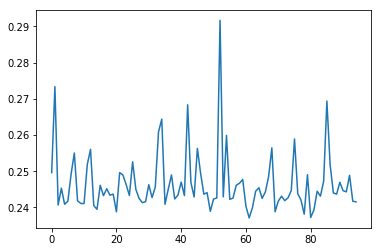

In [122]:
plt.plot(BO_results['loss'])

The `.results` attribute of the `Trials` object has all information from the objective function. If we sort this by the lowest loss, we can see the hyperparameters that performed the best in terms of validation loss. 

In [123]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'loss': 0.23710034270814861,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.7094026916492178,
   'learning_rate': 0.023666748571750607,
   'min_child_samples': 215,
   'num_leaves': 41,
   'reg_alpha': 0.49096778141461983,
   'reg_lambda': 0.4848426662374598,
   'subsample_for_bin': 240000,
   'subsample': 0.918427842159593},
  'iteration': 62,
  'estimators': 168,
  'train_time': 1.4420827190006094,
  'status': 'ok'},
 {'loss': 0.2372173985632462,
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.6473837532360774,
   'learning_rate': 0.04387161637944868,
   'min_child_samples': 235,
   'num_leaves': 115,
   'reg_alpha': 0.4612384236560395,
   'reg_lambda': 0.5181646054438902,
   'subsample_for_bin': 80000,
   'subsample': 0.8155851168061561},
  'iteration': 81,
  'estimators': 92,
  'train_time': 0.9768550629996753,
  'status': 'ok'}]

We can also access the results from the csv file (which might be easier since it's already a dataframe).

In [19]:
#results = pd.read_csv('gbm_trials.csv')
results = pd.read_csv('BO_results.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,Unnamed: 0,loss,params,iteration,estimators,time
0,61,0.237100,"{'boosting_type': 'gbdt', 'class_weight': None...",62,168,1.442083
1,80,0.237217,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",81,92,0.976855
2,78,0.238129,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",79,130,1.271689
3,20,0.238766,"{'boosting_type': 'gbdt', 'class_weight': None...",21,82,0.973122
4,69,0.238791,"{'boosting_type': 'gbdt', 'class_weight': None...",70,169,1.307692


For some reason, when we save to a file and then read back in, the dictionary of hyperparameters is represented as a string. To convert from a string back to a dictionary we can use the `ast` library and the `literal_eval` function.

In [21]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7094026916492178,
 'learning_rate': 0.023666748571750607,
 'min_child_samples': 215,
 'num_leaves': 41,
 'reg_alpha': 0.49096778141461983,
 'reg_lambda': 0.4848426662374598,
 'subsample_for_bin': 240000,
 'subsample': 0.918427842159593}

Now let's try optimizing hyperparameters using hyperopt rand.suggest

In [46]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best_RANDOM = fmin(fn = objective_random, space = space, algo = rand.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

In [47]:
RANDOM_results.to_csv('RANDOM_results.csv')

In [52]:
rand_trials.best_trial

{'state': 2,
 'tid': 70,
 'spec': None,
 'result': {'loss': 0.2369341831360271,
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.6014610964268584,
   'learning_rate': 0.10593108376711306,
   'min_child_samples': 205,
   'num_leaves': 30,
   'reg_alpha': 0.9554058687588726,
   'reg_lambda': 0.7551270460332415,
   'subsample_for_bin': 20000,
   'subsample': 0.7969085111663032},
  'iteration': 71,
  'estimators': 37,
  'train_time': 0.7136297479883069,
  'status': 'ok'},
 'misc': {'tid': 70,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'boosting_type': [70],
   'class_weight': [70],
   'colsample_by_tree': [70],
   'dart_subsample': [],
   'gdbt_subsample': [70],
   'learning_rate': [70],
   'min_child_samples': [70],
   'num_leaves': [70],
   'reg_alpha': [70],
   'reg_lambda': [70],
   'subsample_for_bin': [70]},
  'vals': {'boosting_type': [0],
   'class_weight': [1],
   'colsample_by_tree': [0.60146109642

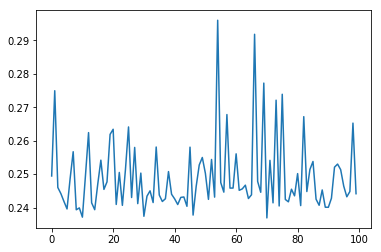

In [54]:
plt.plot(RANDOM_results['loss'])

In [55]:
results_RAND = pd.read_csv('RANDOM_results.csv')

# Sort with best scores on top and reset index for slicing
results_RAND.sort_values('loss', ascending = True, inplace = True)
results_RAND.reset_index(inplace = True, drop = True)
results_RAND.head()

,Unnamed: 0,loss,params,iteration,estimators,time
0,70,0.236934,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",71,37,0.713630
1,10,0.237166,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",11,6,0.882991
2,30,0.237420,"{'boosting_type': 'dart', 'class_weight': 'bal...",31,274,213.840852
3,46,0.237782,"{'boosting_type': 'dart', 'class_weight': 'bal...",47,37,153.848199
4,8,0.239368,"{'boosting_type': 'dart', 'class_weight': None...",9,15,243.161139


## Evaluate Best Results

Now for the moment of truth: did the optimization pay off? For this problem with a relatively small dataset, the benefits of hyperparameter optimization compared to random search are probably minor (if there are any). Random search might turn up a better result in fewer iterations simply becuase of randomness! 

In [22]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7094026916492178, importance_type='split',
        learning_rate=0.023666748571750607, max_depth=-1,
        min_child_samples=215, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=168, n_jobs=-1, num_leaves=41, objective='binary',
        random_state=50, reg_alpha=0.49096778141461983,
        reg_lambda=0.4848426662374598, silent=True,
        subsample=0.918427842159593, subsample_for_bin=240000,
        subsample_freq=0)

In [23]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.73033 AUC ROC on the test set.
This was achieved after 62 search iterations


In [56]:
# Extract the ideal number of estimators and hyperparameters
best_RAND_estimators = int(results_RAND.loc[0, 'estimators'])
best_RAND_params = ast.literal_eval(results_RAND.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_RAND_model = lgb.LGBMClassifier(n_estimators=best_RAND_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_RAND_params)
best_RAND_model.fit(features, labels)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.6014610964268584, importance_type='split',
        learning_rate=0.10593108376711306, max_depth=-1,
        min_child_samples=205, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=37, n_jobs=-1, num_leaves=30, objective='binary',
        random_state=50, reg_alpha=0.9554058687588726,
        reg_lambda=0.7551270460332415, silent=True,
        subsample=0.7969085111663032, subsample_for_bin=20000,
        subsample_freq=0)

In [57]:
# Evaluate on the testing data 
preds = best_RAND_model.predict_proba(test_features)[:, 1]
print('The best model from hyperopt random optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results_RAND.loc[0, 'iteration']))

The best model from hyperopt random optimization scores 0.73041 AUC ROC on the test set.
This was achieved after 71 search iterations


The Bayes Optimization scored slightly higher on the test data ROC AUC (here unlike the loss, higher is better) but also took more iterations to reach the best score (if the notebook is re-run, the results may change). The Bayesian Optimization also does better in terms of the validation loss (1 - ROC AUC) scoring 0.229 compared to 0.231. Due to the small differences, it's hard to say that Bayesian Optimization is better for this particular problem. As with any other machine learning technique, the effectiveness of Bayesian Optimization will be problem dependent. For this problem, we see a slight benefit but it is also possible that random search may find a better set of hyperparameters.

# Comparison to Random Search

Comparing the results to random seach both in numbers and figures can help us understand how Bayesian Optimization searches work. First, we can look at the best hyperparameters (as determined from the validation error) from both searches.

### Optimal Hyperparameters

We can compare the "best" hyperparameters found from both search methods. It's interesting to compare the results because they suggest there may be multiple configurations that yield roughly the same validation error. 

In [61]:
best_random_params['method'] = 'random search implemented manully'
best_bayes_params['method'] = 'Bayesian optimization by hyperopt'
best_RAND_params['method'] = 'random search by hyperopt'

best_params = pd.DataFrame(best_bayes_params, index = [0]).append([pd.DataFrame(best_random_params, index = [0]),
                                                                   pd.DataFrame(best_RAND_params, index = [0])], 
                                                                  ignore_index = True, sort = True)
best_params

,boosting_type,class_weight,colsample_bytree,learning_rate,method,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample,subsample_for_bin
0,gbdt,None,0.709403,0.023667,Bayesian optimization by hyperopt,215,41,0.490968,0.484843,0.918428,240000
1,goss,balanced,0.822222,0.100989,random search implemented manully,460,76,0.612245,1.000000,1.000000,80000
2,gbdt,balanced,0.601461,0.105931,random search by hyperopt,205,30,0.955406,0.755127,0.796909,20000


The top row is the Bayesian Optimization and the bottom row is random search. 

## Visualizing Hyperparameters

One interesting thing we can do with the results is to see the different hyperparameters tried by both random search and the Tree Parzen Estimator. Since random search is choosing without regards to the previous results, we would expect that the distribution of samples should be close to the domain space we defined (it won't be exact since we are using a fairly small number of iterations). On the other hand, the Bayes Optimization, if given enough time, should concetrate on the "more promising" hyperparameters. 

In addition to a more concentrated search, we expect that the average validation loss of the Bayesian Optimization should be lower than that on the random search because it chooses values likely (according to the probability model) to yield lower losses on the objective function. The validation loss should also decrease over time with the Bayesian method. 

First we will need to extract the hyperparameters from both search methods. We will store these in separate dataframes.

In [79]:
# Create a new dataframe for storing parameters of random search implemented manually
random_params = pd.DataFrame(columns = list(ast.literal_eval(random_results.loc[0, 'params']).keys()),
                            index = list(range(len(random_results))))

# Add the results with each parameter a different column
for i, params in enumerate(random_results['params']):
    random_params.loc[i, :] = list(ast.literal_eval(params).values())
    
random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']
random_params.head()


,class_weight,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,loss,iteration
0,balanced,goss,76,0.100989,80000,460,0.612245,1,0.822222,1,0.239105,0
1,balanced,gbdt,68,0.0105998,140000,145,0.142857,0.857143,0.644444,0.505051,0.239180,14
2,balanced,gbdt,50,0.0159028,180000,245,0,1,0.822222,0.656566,0.239289,38
3,None,gbdt,78,0.0472003,200000,220,0.55102,1,0.644444,0.838384,0.239328,30
4,balanced,dart,80,0.0394336,120000,125,0.612245,0.673469,0.688889,0.671717,0.239977,64


In [80]:
# Create a new dataframe for storing parameters of bayesian optimization by hyperopt
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

,boosting_type,class_weight,colsample_bytree,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,loss,iteration
0,gbdt,None,0.709403,0.0236667,215,41,0.490968,0.484843,240000,0.918428,0.237100,62
1,gbdt,balanced,0.647384,0.0438716,235,115,0.461238,0.518165,80000,0.815585,0.237217,81
2,gbdt,balanced,0.684361,0.024138,235,94,0.42347,0.347299,120000,0.81704,0.238129,79
3,gbdt,None,0.76502,0.0365475,245,149,0.277453,0.127306,240000,0.992397,0.238766,21
4,gbdt,None,0.721719,0.0239214,250,63,0.22728,0.0889264,200000,0.934048,0.238791,70


In [85]:
# Create a new dataframe for storing parameters of random search by hyperopt
rand_ho_params = pd.DataFrame(columns = list(ast.literal_eval(results_RAND.loc[0, 'params']).keys()),
                            index = list(range(len(results_RAND))))

# Add the results with each parameter a different column
for i, params in enumerate(results_RAND['params']):
    rand_ho_params.loc[i, :] = list(ast.literal_eval(params).values())
    
rand_ho_params['loss'] = results_RAND['loss']
rand_ho_params['iteration'] = results_RAND['iteration']

rand_ho_params.head()

,boosting_type,class_weight,colsample_bytree,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,loss,iteration
0,gbdt,balanced,0.601461,0.105931,205,30,0.955406,0.755127,20000,0.796909,0.236934,71
1,gbdt,balanced,0.787872,0.0795365,410,132,0.176167,0.723457,180000,0.521175,0.237166,11
2,dart,balanced,0.692512,0.0489036,230,35,0.382078,0.552,140000,0.519552,0.237420,31
3,dart,balanced,0.728129,0.0116884,435,88,0.833814,0.849099,240000,0.736911,0.237782,47
4,dart,None,0.667308,0.0613611,475,70,0.86951,0.440767,160000,0.998529,0.239368,9


#### Learning Rates

The first plot shows the sampling distribution, random search, and Bayesian optimization learning rate distributions. 

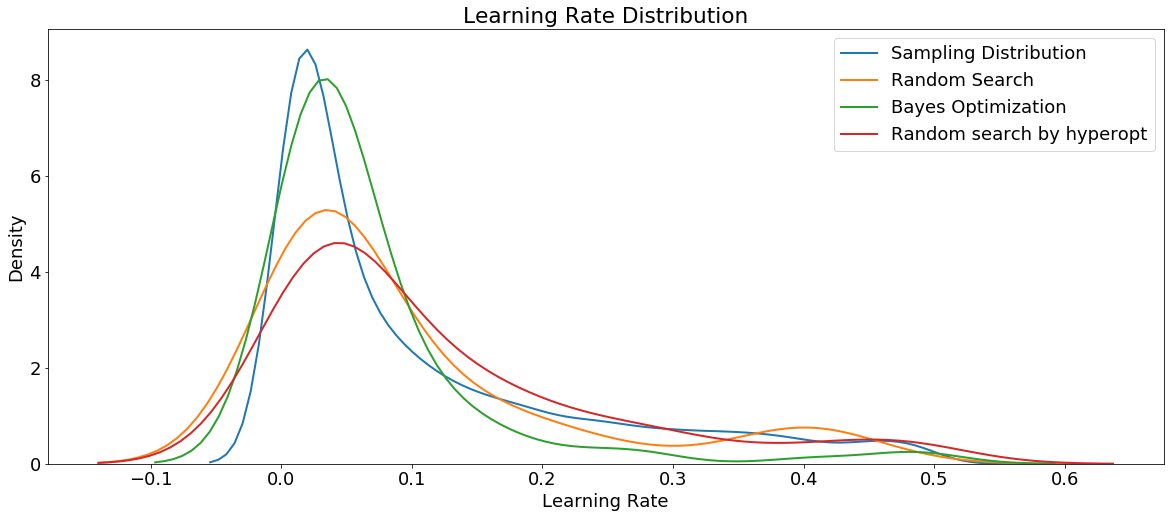

In [88]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 2)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 2)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 2)
sns.kdeplot(rand_ho_params['learning_rate'], label = 'Random search by hyperopt', linewidth = 2)
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

#### Boosting Type 

Random search should use the boosting types with the same frequency. However, Bayesian Optimization might have decided (modeled) that one boosting type is better than another for this problem.

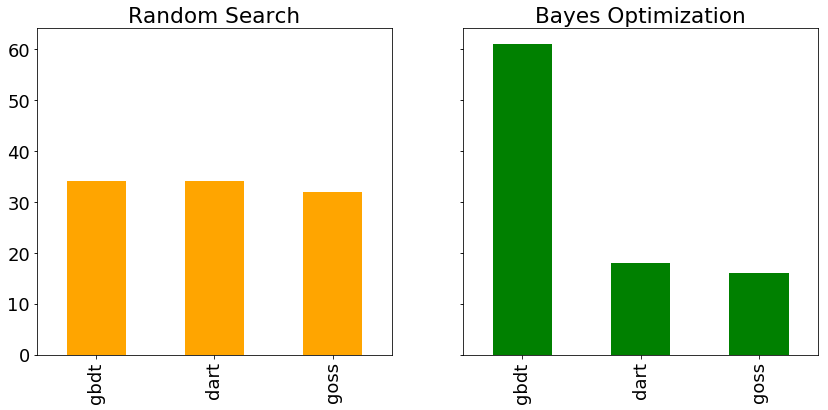

In [101]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization');
#rand_ho_params['boosting_type'].value_counts().plot.bar(ax = axs[2], figsize = (14, 6), color = 'blue', title = 'Random search by HO');

In [102]:
print('Random Search boosting type percentages')
100 * random_params['boosting_type'].value_counts() / len(random_params)

Random Search boosting type percentages


goss    34.0
dart    34.0
gbdt    32.0
Name: boosting_type, dtype: float64

In [103]:
print('Bayes Optimization boosting type percentages')
100 * bayes_params['boosting_type'].value_counts() / len(bayes_params)

Bayes Optimization boosting type percentages


gbdt    64.210526
dart    18.947368
goss    16.842105
Name: boosting_type, dtype: float64

In [94]:
print('Random search by HO boosting type percentages')
100 * rand_ho_params['boosting_type'].value_counts() / len(bayes_params)

Random search by HO boosting type percentages


dart    42.105263
gbdt    34.736842
goss    28.421053
Name: boosting_type, dtype: float64

Sure enough, the Bayesian Optimization tried the gradient boosted decision tree boosting type much more than the other two. We could use this information to inform subsequent searches for the best hyperparameters by focusing on a smaller domain.

### Plots of All Numeric Hyperparameters

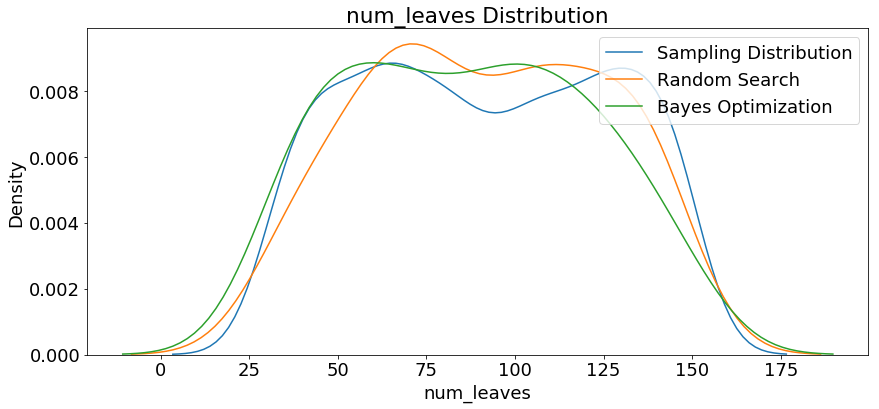

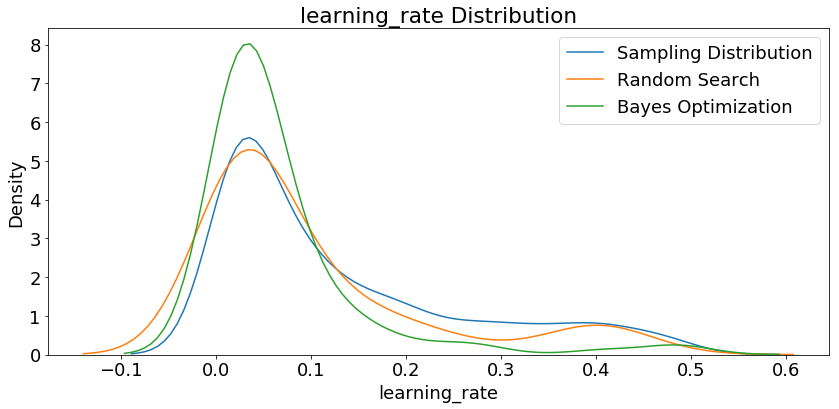

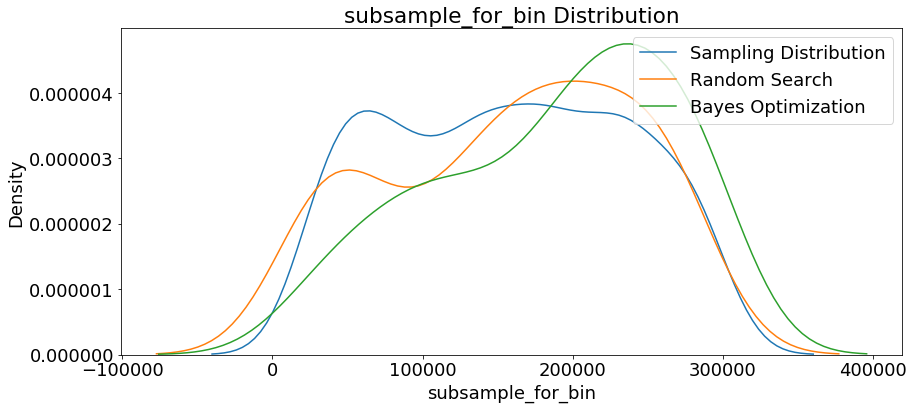

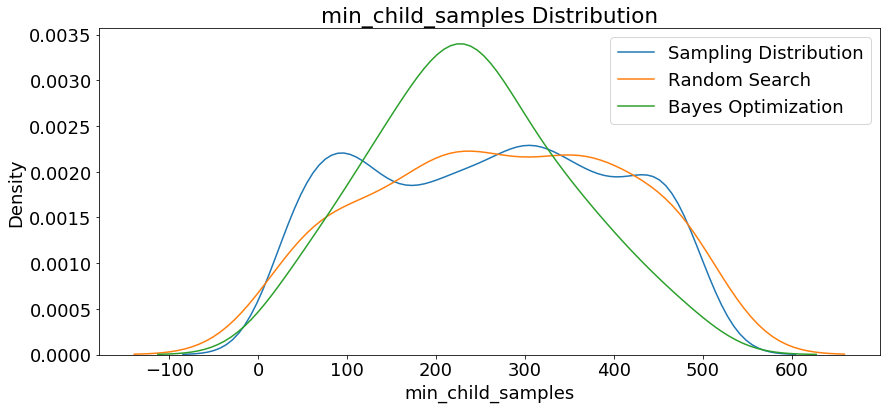

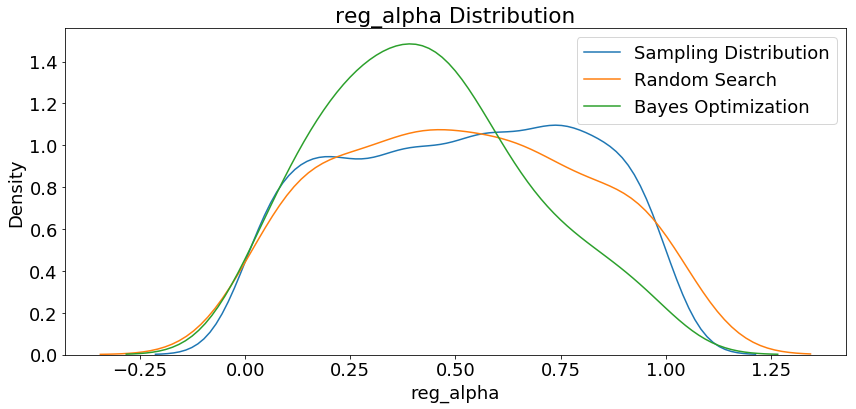

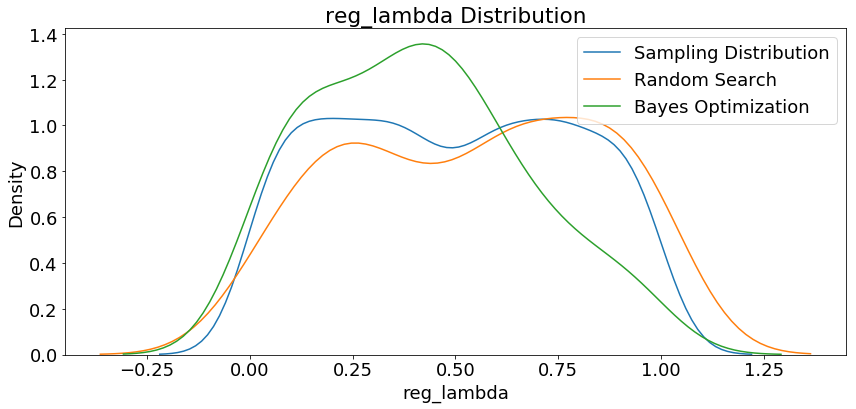

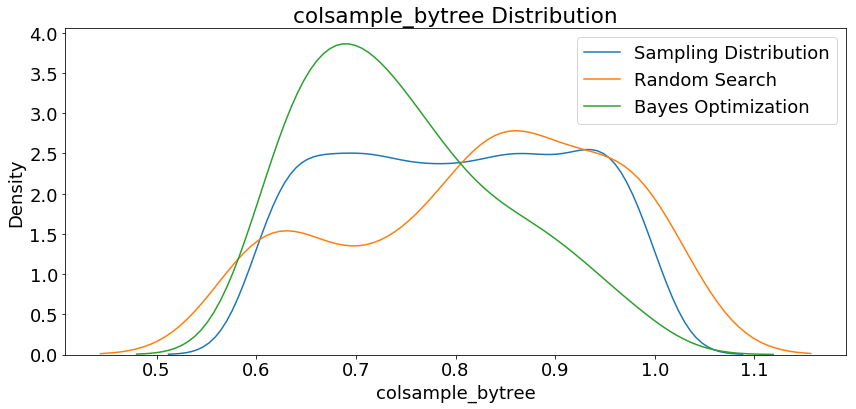

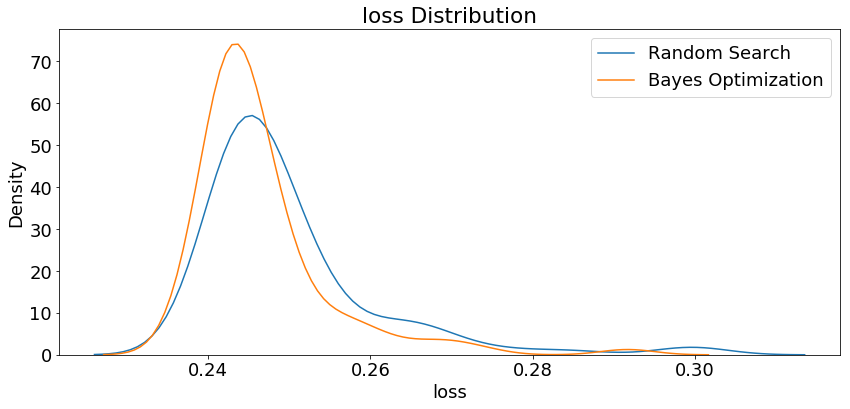

In [104]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'boosting_type', 'iteration', 'subsample', 'metric', 'verbose']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
        sns.kdeplot(random_params[hyper], label = 'Random Search')
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization')
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

The final graph shows that the validation loss for Bayesian Optimization tends to be lower than than from Random Search. This should give us confidence the method is working correctly. Again, this does not mean the hyperparameters found during Bayesian Optimization are necessarily better for the test set, only that they yield a lower loss in cross validation.

## Evolution of Hyperparameters Searched

We can also plot the hyperparameters over time (against the number of iterations) to see how they change for the Bayes Optimization. First we will map the `boosting_type` to an integer for plotting.

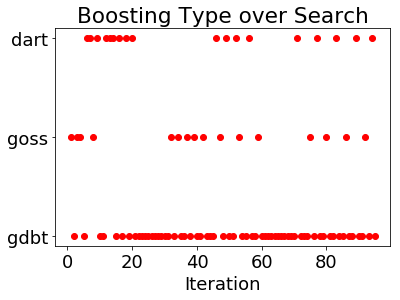

In [105]:
# Map boosting type to integer (essentially label encoding)
bayes_params['boosting_int'] = bayes_params['boosting_type'].replace({'gbdt': 1, 'goss': 2, 'dart': 3})

# Plot the boosting type over the search
plt.plot(bayes_params['iteration'], bayes_params['boosting_int'], 'ro')
plt.yticks([1, 2, 3], ['gdbt', 'goss', 'dart']);
plt.xlabel('Iteration'); plt.title('Boosting Type over Search');

There is not much change over time for this hyperparameter: `gdbt` is dominant for the entire stretch.

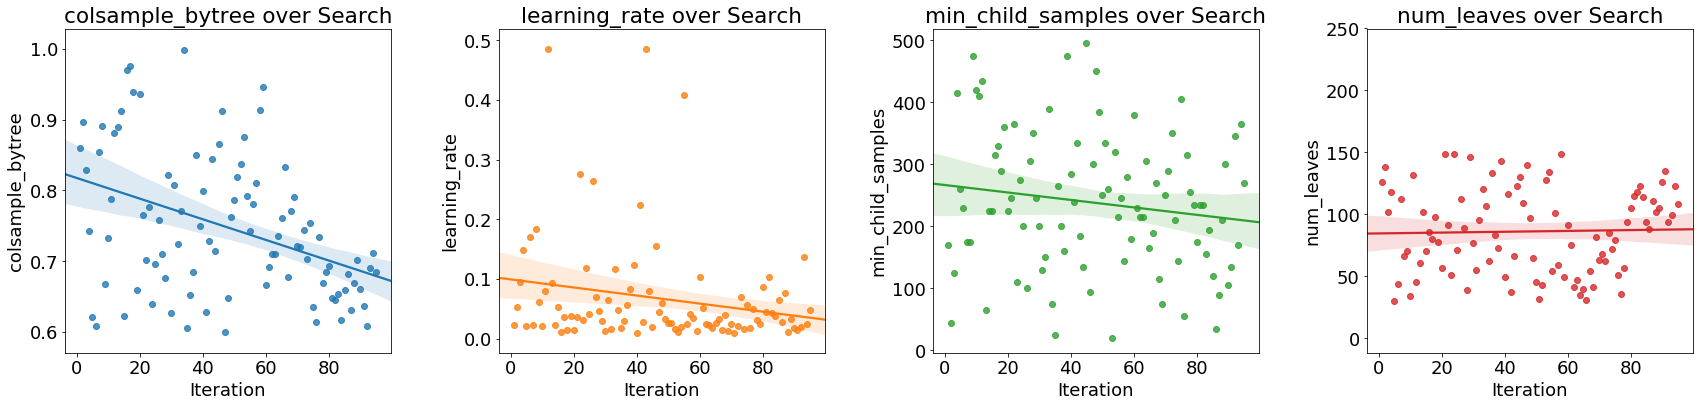

In [106]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

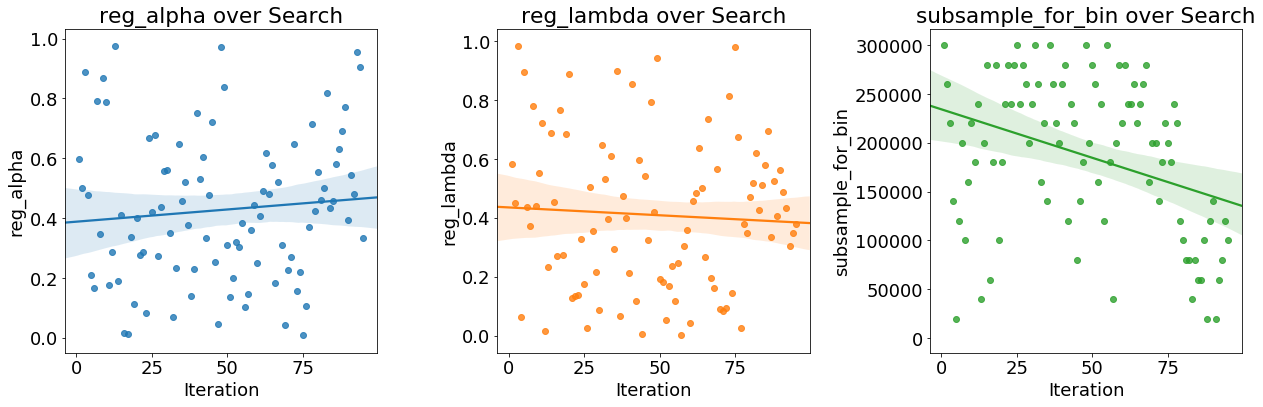

In [108]:
fig, axs = plt.subplots(1, 3, figsize = (18, 6))
i = 0

# Scatterplot of next three hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

If there are trends in these plots, we can use them to inform subsequent searches. We might even want to use grid search focusing on a much smaller region of hyperparameter space based on the Bayesian Optimization results.

#### Validation Losses

Finally, we can look at the losses recorded by both random search and Bayes Optimization. We would expect the average loss recorded by Bayes Optimization to be lower because this method should spend more time in promising regions of the search space.

In [114]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': 1 - random_params['loss'], 'iteration': random_params['iteration'], 'search': 'random'})
scores = scores.append(pd.DataFrame({'ROC AUC': 1 - bayes_params['loss'], 'iteration': bayes_params['iteration'], 'search': 'Bayes'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

,ROC AUC,iteration,search
0,0.760895,0,random
1,0.760820,14,random
2,0.760711,38,random
3,0.760672,30,random
4,0.760023,64,random


In [121]:
scores.groupby(['search']).mean()

,ROC AUC,iteration
search,,
Bayes,0.753505,48.0
random,0.750147,49.5


We can make histograms of the scores (not taking in account the iteration) on the same x-axis scale to see if there is a difference in scores.

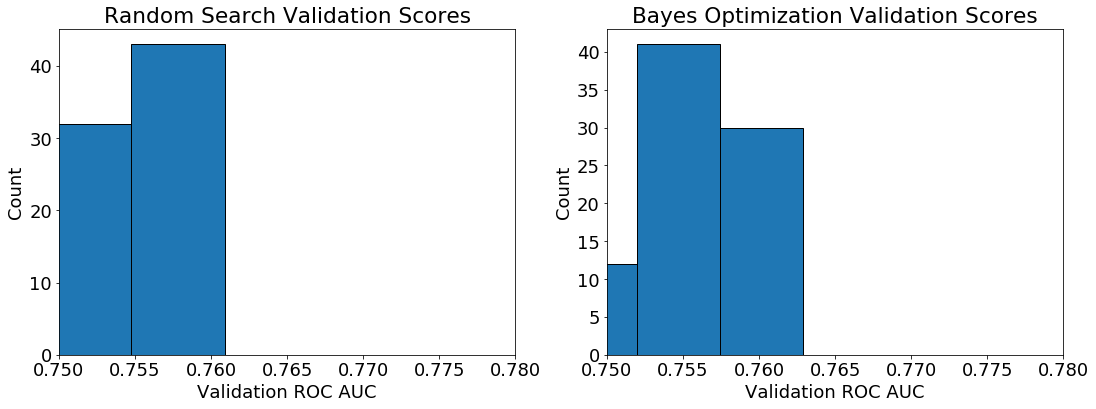

In [115]:
plt.figure(figsize = (18, 6))

# Random search scores
plt.subplot(1, 2, 1)
plt.hist(1 - random_results['loss'].astype(np.float64), label = 'Random Search', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Random Search Validation Scores")
plt.xlim(0.75, 0.78)

# Bayes optimization scores
plt.subplot(1, 2, 2)
plt.hist(1 - bayes_params['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Bayes Optimization Validation Scores");
plt.xlim(0.75, 0.78);

It does appear that the validation ROC AUC for the Bayesian optimization is higher than that for Random Search. However, as we have seen, this does not necessarily translate to a better testing score! 

Bayesian optimization should get better over time. Let's plot the scores against the iteration to see if there was improvement.

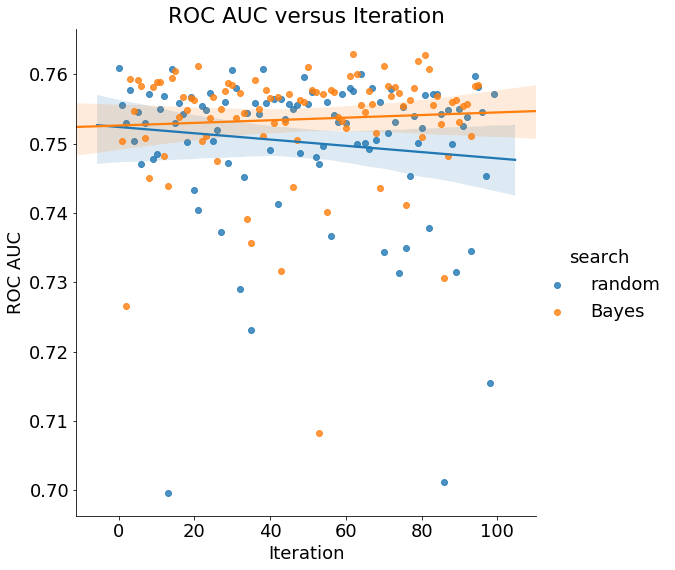

In [119]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, height = 8);
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("ROC AUC versus Iteration");

It's reassuring to see that the validation ROC AUC scores of Bayesian optimization increase over time. What this shows is that the model is exploring hyperparameters that are better according to the cross validation metric! It would be interesting to continue searching and see if there is a plateau in the validation scores (there would have to be eventually). Moreover, even if validation scores continue to increase, that does not mean a better model for the testing data! 

If we want to save to save the trials results, we can use the json format. 

In [55]:
import json

# Save the trial results
with open('results/trials.json', 'w') as f:
    f.write(json.dumps(bayes_trials.results))

In [56]:
# Save dataframes of parameters
bayes_params.to_csv('results/bayes_params.csv', index = False)
random_params.to_csv('results/random_params.csv', index = False)

## Continue Searching

We can keep running the Bayesian hyperparameter search for more iterations to try for better results. Hyperopt will continue searching where it left off if we [pass it a trials object that already has information on previous runs](https://github.com/hyperopt/hyperopt/issues/267). This raises a good point: always save your previous results, because you never know when they will be useful! 

Another interesting point to not is that Bayesian Optimization methods do not have any internal state which means all they need are the results: previous inputs to the objective function and the resulting loss. Based only on these results, these methods can construct a surrogate function and suggest the next set of hyperparameters to evaluate. The internals of the objective function have no effect on the Bayesian Optimization method hence the naming of this as a black box optimization method.

In [57]:
# Continue training
ITERATION = MAX_EVALS + 1

# Set more evaluations
MAX_EVALS = 1000

In [58]:
%%capture

# Use the same trials object to keep training
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, verbose = 1, rstate = np.random.RandomState(50))

In [59]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'estimators': 138,
  'iteration': 846,
  'loss': 0.22763293220783154,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.6311794044268164,
   'learning_rate': 0.027802518491219938,
   'metric': 'auc',
   'min_child_samples': 250,
   'num_leaves': 40,
   'reg_alpha': 0.06183118355912668,
   'reg_lambda': 0.24742831407472365,
   'subsample': 0.999742610271968,
   'subsample_for_bin': 280000,
   'verbose': 1},
  'status': 'ok',
  'train_time': 2.2477611396880093},
 {'estimators': 151,
  'iteration': 743,
  'loss': 0.2282586680303902,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.654904101723946,
   'learning_rate': 0.022834417861761228,
   'metric': 'auc',
   'min_child_samples': 255,
   'num_leaves': 41,
   'reg_alpha': 0.11894237903920345,
   'reg_lambda': 0.8792019672260676,
   'subsample': 0.911075761769854,
   'subsample_for_bin': 280000,
   'verbose': 1},
  'status': 'ok',
  'train_time': 2.357131641913

In [60]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort values with best on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.227633,"{'boosting_type': 'gbdt', 'class_weight': None...",846,138,2.247761
1,0.228259,"{'boosting_type': 'gbdt', 'class_weight': None...",743,151,2.357132
2,0.228292,"{'boosting_type': 'gbdt', 'class_weight': None...",837,182,2.772181
3,0.228591,"{'boosting_type': 'gbdt', 'class_weight': None...",887,160,2.469558
4,0.228959,"{'boosting_type': 'gbdt', 'class_weight': None...",696,204,2.948316


In [61]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.6311794044268164,
        learning_rate=0.027802518491219938, max_depth=-1, metric='auc',
        min_child_samples=250, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=138, n_jobs=-1, num_leaves=40, objective='binary',
        random_state=50, reg_alpha=0.06183118355912668,
        reg_lambda=0.24742831407472365, silent=True,
        subsample=0.999742610271968, subsample_for_bin=280000,
        subsample_freq=1, verbose=1)

In [62]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.72736 AUC ROC on the test set.
This was achieved after 846 search iterations


The continuation of the search did slightly improve the validation score (again depending on training run). Instead of training more, we might want to restart the search so the algorithm can spend more time exploring the domain space. As searching continues, the algorithm shifts from exploring (trying new values) to exploiting (trying those values that worked best in the past). This is generally what we want unless the model gets stuck in a local minimum at which point we would want to restart the search in a different region of the hyperparameter space. Bayesian Optimization of hyperparameters is still prone to overfitting, even when using cross-validation because it can get settle into a local minimum of the objective function. It is very difficult to tell when this occurs for a high-dimensional problem!

# Conclusions

In this notebook, we saw how to implement automated hyperparameter tuning with Bayesian Optimization methods. We used the open-source Python library Hyperopt with the Tree Parzen Estimator to optimize the hyperparameters of a gradient boosting machine. 

Bayesian model-based optimization can be more efficient than random search, finding a better set of model hyperparameters in fewer search iterations (although not in every case). However, just because the model hyperparameters are better on the validation set does not mean they are better for the testing set! For this training run, Bayesian Optimization found a better set of hyperparamters according to the validation and the test data although the testing score was much lower than the validation ROC AUC. This is a useful lesson that even when using cross-validation, overfitting is still one of the top problems in machine learning. 

Bayesian optimization  is a powerful technique that we can use to tune any machine learning model, so long as we can define an objective function that returns a value to minimize and a domain space over which to search. This can extend to any function that we want to minimize (not just hyperparameter tuning). Bayesian optimization can be a significant upgrade over uninformed methods such as random search and because of the ease of use in Python are now a good option to use for hyperparameter tuning. As with most subjects in machine learning, there is no single best answer for hyperparameter tuning, but Bayesian optimization methods should be a tool that helps data scientists with the tedious but necessary task of model tuning! 